---
# Alignment

An issue is that if your subject moves across runs, you will need to designate CSF and WM voxels separately for each run, because otherwise your acompcorr analysis will obviously pick up task-related signals because you’re sampling gray matter. That’s a danger you would want to expressly avoid. Hence, I now do the following:

1) For each run, manually align the runs to the first acquired slice. This slice is the closest to the low-resolution anatomy, so we can use this to transform our segmentations
2) Insert the list of transformations into `linescanning.Segmentations`, so that `call_antsapplytransforms` implements both transformations to warp the segmentations to each run separately

In [1]:
from linescanning import utils,prf,dataset,plotting, segmentations
import numpy as np
import warnings
import matplotlib.pyplot as plt
from pRFline import fitting
from scipy import signal
import os
opj = os.path.join

warnings.simplefilter('ignore')
project_dir     = os.environ.get("DIR_PROJECTS")
base_dir        = os.path.join(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox        = 359
plot_xkcd       = False
np.set_printoptions(precision=3)


/home/gjheij/anaconda3/envs/prfline/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/gjheij/anaconda3/envs/prfline/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
# Load data
sub         = '003'
ses         = 4
task        = "task-pRF"
run         = [2,5]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
anat_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "anat")
trafo_dir   = opj(base_dir, 'testing', 'alignment')
log_dir     = "/mnt/d/FSL/shared/spinoza/programs/project_repos/LineExps/lineprf/logs/sub-003_ses-0_task-pRF_run-imgs"
prf_new     = opj(base_dir, 'derivatives', 'prf', f"sub-{sub}", f"ses-{ses}")
ribbon      = [357,364]

if not os.path.exists(prf_new):
    os.makedirs(prf_new, exist_ok=True)

In [4]:
run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir, exclude="run-2")
func_file = utils.get_file_from_substring("bold.mat", run_files)
ref_slices = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", "acq-1slice", ".nii.gz"], anat_dir, exclude="run-2")
ref_slices

['/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-4_T1w.nii.gz',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-5_T1w.nii.gz',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-6_T1w.nii.gz']

Load the transformation files; should be a `from-fs_to-sesX_desc-genaff.mat`-file and the manually create `from-runX_to-runX.mat`-file

DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Filtering strategy: 'hp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-4
 Foldover: FH
 Ref slice: /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-4_T1w.nii.gz
 Found 61 voxels for nuisance regression
 We're good to go!
 Using 5 components for aCompCor (WM/CSF separately)
 Found 2 component(s) in 'csf'-voxels with total explained variance of 0.61%
 Found 1 component(s) in 'wm'-voxels with total explained variance of 0.72%
 DCT high-pass filter on components [removes low frequencies <0.2 Hz]

DATASET: created
Fetching dataframe from attribute 'df_func_zscore'
DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/fu

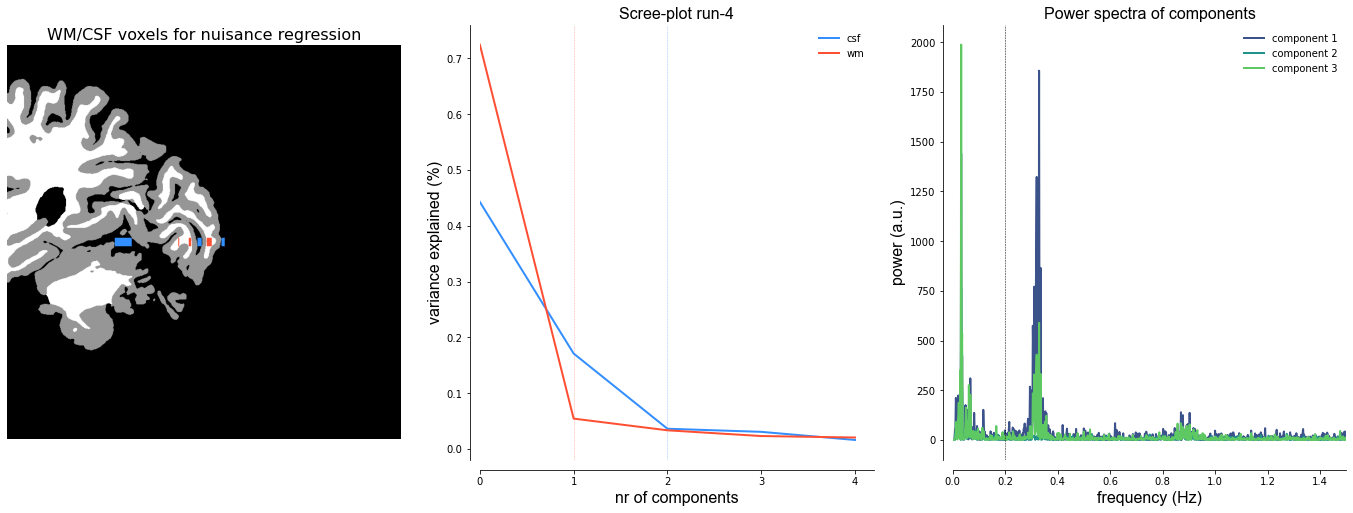

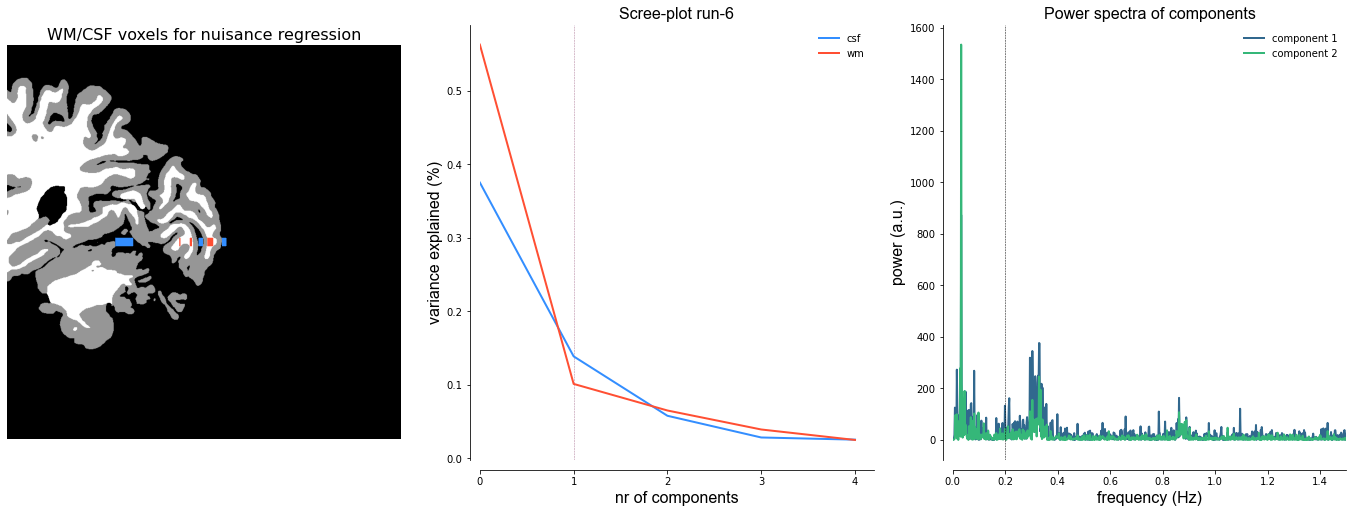

In [17]:
window = 19
order = 3

lp = False

# get FS-to-ses transformation
trafo = utils.get_file_from_substring("from-fs_", trafo_dir)

# run specific transformation
trafo_run = utils.get_file_from_substring("to-run4", trafo_dir)

# make into list
trafo_list = [trafo, trafo_run]

# fetch correct reference slice
ref_slice = utils.get_file_from_substring("run-4", ref_slices)
func = utils.get_file_from_substring("run-4", func_file)

# run 4
run4 = dataset.Dataset(func,
                       use_bids=True,
                       verbose=True,
                       acompcor=True,
                       ref_slice=ref_slice,
                       trafo_file=trafo_list,
                       n_pca=5)

run4_func = run4.fetch_fmri()

# run 6
trafo_run = utils.get_file_from_substring("to-run6", trafo_dir)
trafo_list = [trafo, trafo_run]

# fetch correct reference slice
ref_slice = utils.get_file_from_substring("run-6", ref_slices)
func = utils.get_file_from_substring("run-6", func_file)

run6 = dataset.Dataset(func,
                       use_bids=True,
                       verbose=True,
                       acompcor=True,
                       ref_slice=ref_slice,
                       trafo_file=trafo_list,
                       n_pca=5)

run6_func = run6.fetch_fmri()


As we can see, different voxels were selected for different runs. This also means the voxels in each run won't be perfectly aligned. In other words, voxel 382 can be gray matter in one run, and white matter in another. This makes averaging across runs extremely tricky. Ideally, we find a solution that "alignes" the voxels as good as possible. I do this partly already by manually aligning the slices. This particularly helps in selecting WM/CSF voxels

In [24]:
# get the segmentations in beam representation
run4.segmentations_to_beam()
run6.segmentations_to_beam()

# shape = (720,16)
ctx1 = run4.segmentations_in_beam[run4.subject]['cortex']
ctx2 = run6.segmentations_in_beam[run6.subject]['cortex']


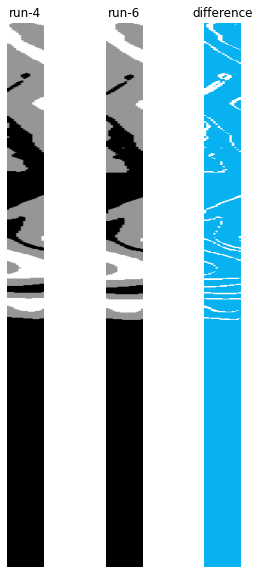

In [33]:
fig = plt.figure(figsize=(5,10))
gs = fig.add_gridspec(1,3)

aspect = 1/3
cmap1 = "Greys_r"
cmap2 = utils.make_binary_cm("#08B2F0")

# cortex beam in run-4
ax1 = fig.add_subplot(gs[0])
ax1.imshow(ctx1, cmap=cmap, aspect=aspect)
ax1.set_title("run-4")

# cortex beam in run-6
ax2 = fig.add_subplot(gs[1])
ax2.imshow(ctx2, cmap=cmap, aspect=aspect)
ax2.set_title("run-6")

# difference
ax3 = fig.add_subplot(gs[2])
ax3.imshow((ctx1 == ctx2).astype(int), cmap=cmap2, aspect=aspect)
ax3.set_title('difference')
for ax in ax1,ax2,ax3:
    ax.axis('off')

The plot above doesn't tell me too much.. Just that there is some shift, but it's not too clear. Below I collapsed over the last axis to get a line profile for both runs, maybe we can do something similar as in this notebook: https://github.com/spinoza-centre/pRFline/blob/main/notebooks/anat/confirm.ipynb

max correlation = 0.99; padding of 1 voxels


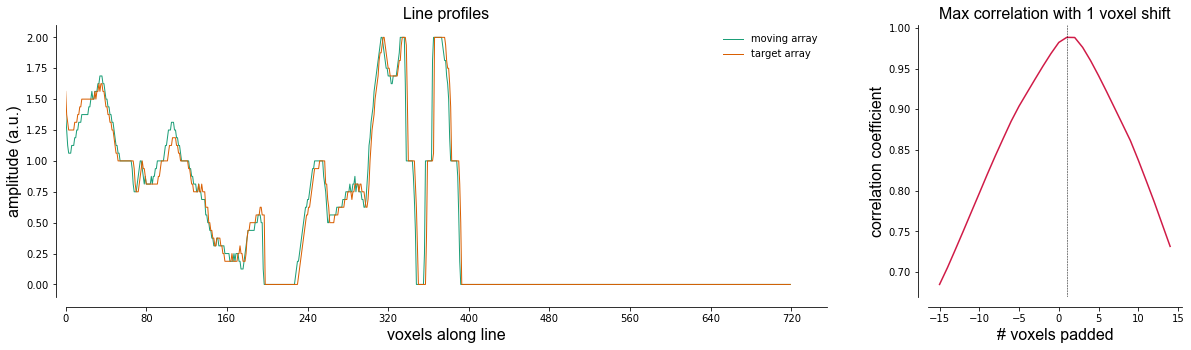

In [158]:
aligner = segmentations.Align(run4, run6, verbose=True)

What to do in case of mismatch between the runs regarding number of GM-voxels.. Only include those voxels that exist across runs?

In [108]:
print(aligner.moving_gm_voxels)
print(aligner.target_gm_voxels)

[310 311 312 313 314 315 316 317 330 331 332 333 334 335 336 364 365 366
 367 368 369 370 371 372 373 374 375 376 377]
[311 312 313 314 315 316 317 318 319 331 332 333 334 335 336 337 338 366
 367 368 369 370 371 372 373 374 375 376 377 378]
